In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time
import sys
import os

import seaborn as sns
import gensim 

In [2]:
import django
import platform

if platform.node() == "srv-mcc-apsis":
    sys.path.append('/home/muef/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/Documents/Data/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
from parliament.tasks import do_search, run_tm
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import *
from utils.tm_mgmt import update_topic_scores
from utils.text import *
from django.db.models import Q, Count, Func, F, Sum, Avg, Value as V
from tmv_app.tasks import get_coherence, get_exclusivity

### DTM runs

In [3]:
method="BD"
search_id = 89
#run_qs =  RunStats.objects.filter(psearch__id=search_id, method=method, status=3, alpha=0.01, top_chain_var=0.005)
run_qs =  RunStats.objects.filter(psearch__id__in=[83, 89], method=method, status=3)

run_ids = [run_id[0] for run_id in run_qs.values_list('run_id')]
print(run_ids)

[2154, 2137, 2145, 2122, 2121, 2120, 2112, 2119, 2111, 2136, 2118, 2143, 2144, 2146, 2147, 2123, 2156, 2155, 2158, 2157, 2167, 2160, 2166, 2161]


In [4]:
for run_id in run_ids:
    if not RunStats.objects.get(run_id=run_id).coherence:
        print("Calculating coherence for run {}".format(run_id))
        get_coherence(run_id)

In [5]:
for run_id in run_ids:
    if not RunStats.objects.get(run_id=run_id).exclusivity:
        print("Calculating exclusivity for run {}".format(run_id))
        get_exclusivity(run_id)

In [6]:
run_df = pd.DataFrame.from_dict(run_qs.values('run_id', 'coherence', 'exclusivity', 'K', 'alpha',
                                'top_chain_var', 'rng_seed', 'max_iter', 'psearch__id'))

#run_df.set_index('run_id')
run_df = run_df.sort_values('run_id').set_index('run_id')
run_df[run_df["K"]== 45]

,K,alpha,coherence,exclusivity,max_iter,psearch__id,rng_seed,top_chain_var
run_id,,,,,,,,
2111,45,0.01,0.508955,0.742253,50,83,1,0.005
2118,45,0.10,0.374046,0.698753,50,83,1,0.100
2119,45,0.10,0.416262,0.824821,50,83,1,0.050
2120,45,0.10,0.491302,0.871996,50,83,1,0.010
2121,45,0.10,0.506084,0.780998,50,83,1,0.005
2122,45,0.05,0.370210,0.701541,50,83,1,0.100
2123,45,0.05,0.410620,0.806679,50,83,1,0.050
2136,45,0.05,0.480421,0.870453,50,83,1,0.010
2137,45,0.05,0.514492,0.775650,50,83,1,0.005


<IPython.core.display.Javascript object>


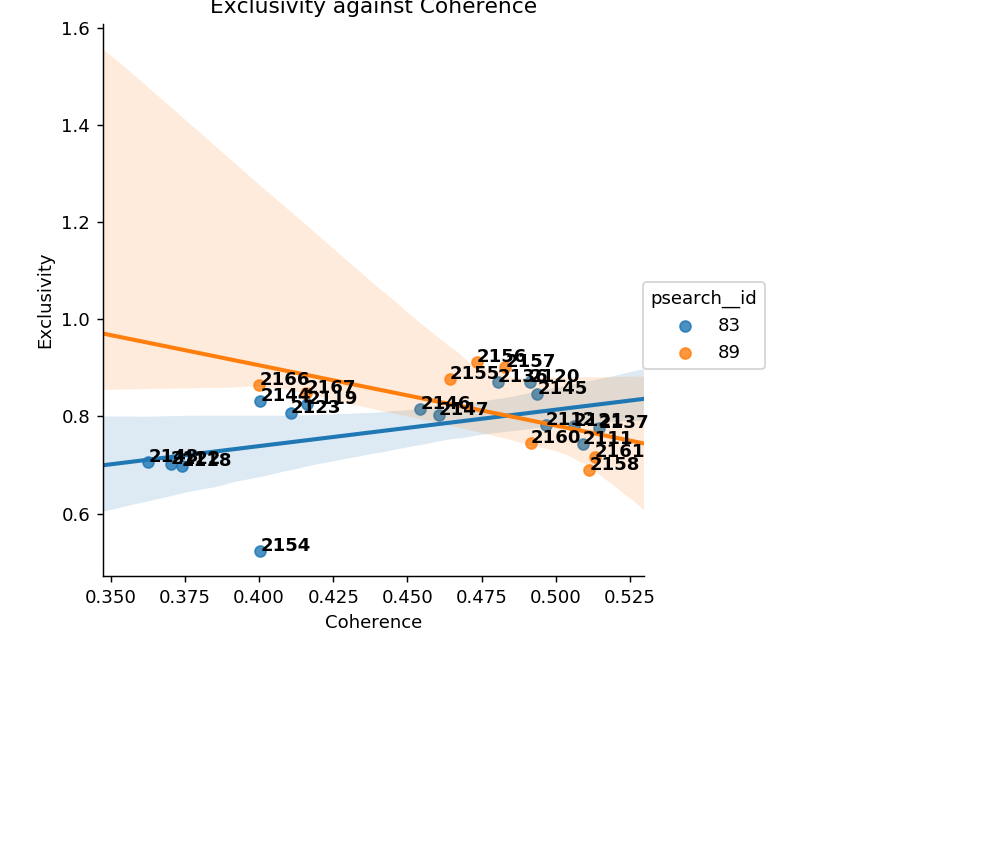

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [7]:
%matplotlib notebook
#fig, ax = plt.subplots(figsize=(10,6))
#p = sns.regplot(x='coherence', y='exclusivity', data=run_df, ax = ax, color='psearch__id')
g = sns.lmplot(x='coherence', y='exclusivity', data=run_df, hue='psearch__id')

ax = plt.gca()
for run_id in run_df.index:
    ax.text(run_df.coherence[run_id], run_df.exclusivity[run_id],
           run_id, horizontalalignment='left', size='medium', color='black', weight='semibold')

ax.set(xlabel="Coherence",ylabel="Exclusivity", title="Exclusivity against Coherence")

click on dots to show parameter settings


<IPython.core.display.Javascript object>


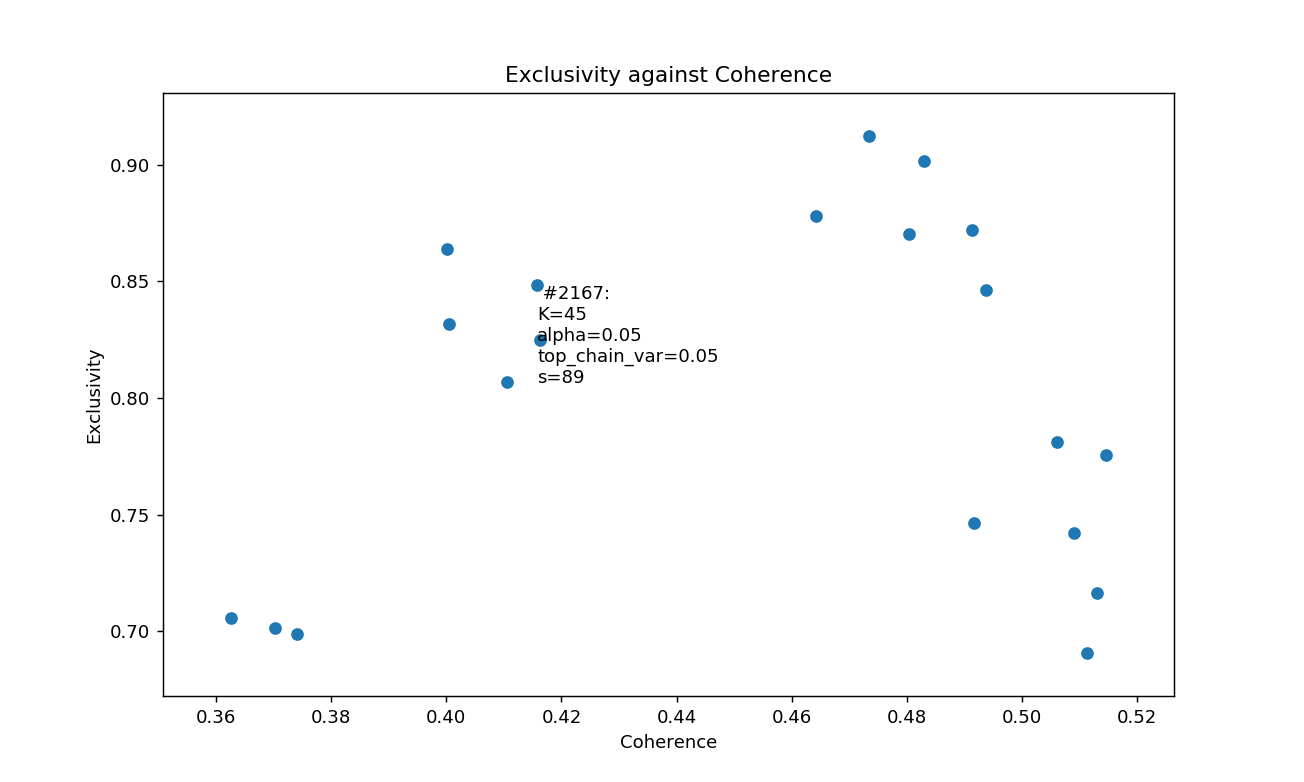

7

In [8]:
%matplotlib notebook

print("click on dots to show parameter settings")

# filter:
select_df = run_df[run_df['K'] == 45]
#select_df = run_df

x = select_df['coherence']
y = select_df['exclusivity']

def onpick3(event):
    ind = event.ind[0]
    run_id = select_df.index[ind]
    label = " #{}:\nK={}\nalpha={}\ntop_chain_var={}\ns={}".format(run_id, select_df['K'][run_id],
                                                           select_df['alpha'][run_id],
                                                           select_df['top_chain_var'][run_id],
                                                           select_df['psearch__id'][run_id])
    text.set_text(label)
    text.set_x(x[run_id])
    text.set_y(y[run_id])


fig, ax = plt.subplots(figsize=(10,6))
col = ax.scatter(x, y, picker=5)
ax.set(xlabel="Coherence",ylabel="Exclusivity", title="Exclusivity against Coherence")
text=ax.text(0,0, "", va="top", ha="left")

fig.canvas.mpl_connect('pick_event', onpick3)


In [10]:
# measure concentration in the distribution of topics

def gini(x):
    # from https://pysal.readthedocs.io/en/latest/_modules/pysal/inequality/gini.html#Gini
    # see also: http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    n = len(x)
    try:
        x_sum = x.sum()
    except AttributeError:
        x = np.asarray(x)
        x_sum = x.sum()
    n_x_sum = n * x_sum
    r_x = (2. * np.arange(1, len(x)+1) * x[np.argsort(x)]).sum()
    return (r_x - n_x_sum - x_sum) / n_x_sum


def gini_array(x, axis=0):
    try:
        n = x.shape[axis]
    except AttributeError:
        x = np.asarray(x)
        n = x.shape[axis]
    m = x.shape[(axis + 1) % 2]
    x_sum = x.sum(axis=axis)
    n_x_sum = n * x_sum
    r_x = np.zeros(m)
    for i in range(m):
        if axis == 1:
            y = x[i]
        else:
            y = x.T[i]
        r_x[i] = (2. * np.arange(1, n + 1) * y[np.argsort(y)]).sum()

        if (r_x[i] - n_x_sum[i] - x_sum[i]) == 0 and n_x_sum[i] == 0:
            n_x_sum[i] = 1

    return (r_x - n_x_sum - x_sum) / n_x_sum

def robin_hood(x):
    """
    Calculate the robin hood (or Hoover) index
    """
    try:
        mean = x.mean()
    except AttributeError:
        x = np.asarray(x)
        mean = x.mean()
    
    return np.abs(x - mean).sum() / (2 * x.sum())

In [11]:
data = []
for run_id in run_ids:
    ts = np.array([score[0] for score in Topic.objects.filter(run_id=run_id).values_list('score')])
    run_df.append([run_id, gini(ts), robin_hood(ts)])
    data.append({'run_id': run_id, 'gini': gini(ts), 'robin_hood': robin_hood(ts)})
ineq_df = pd.DataFrame(data)

In [12]:
ineq_df = ineq_df.sort_values('run_id').set_index('run_id')
df = run_df.join(ineq_df)
df

,K,alpha,coherence,exclusivity,max_iter,psearch__id,rng_seed,top_chain_var,gini,robin_hood
run_id,,,,,,,,,,
2111,45,0.01,0.508955,0.742253,50,83,1,0.005,0.515660,0.363052
2112,50,0.01,0.496631,0.781455,50,83,1,0.005,0.527578,0.376604
2118,45,0.10,0.374046,0.698753,50,83,1,0.100,0.275867,0.187132
2119,45,0.10,0.416262,0.824821,50,83,1,0.050,0.309553,0.209530
2120,45,0.10,0.491302,0.871996,50,83,1,0.010,0.436553,0.297405
2121,45,0.10,0.506084,0.780998,50,83,1,0.005,0.489960,0.342859
2122,45,0.05,0.370210,0.701541,50,83,1,0.100,0.273030,0.182656
2123,45,0.05,0.410620,0.806679,50,83,1,0.050,0.309553,0.207499
2136,45,0.05,0.480421,0.870453,50,83,1,0.010,0.445031,0.309422


click on dots to show parameter settings


<IPython.core.display.Javascript object>


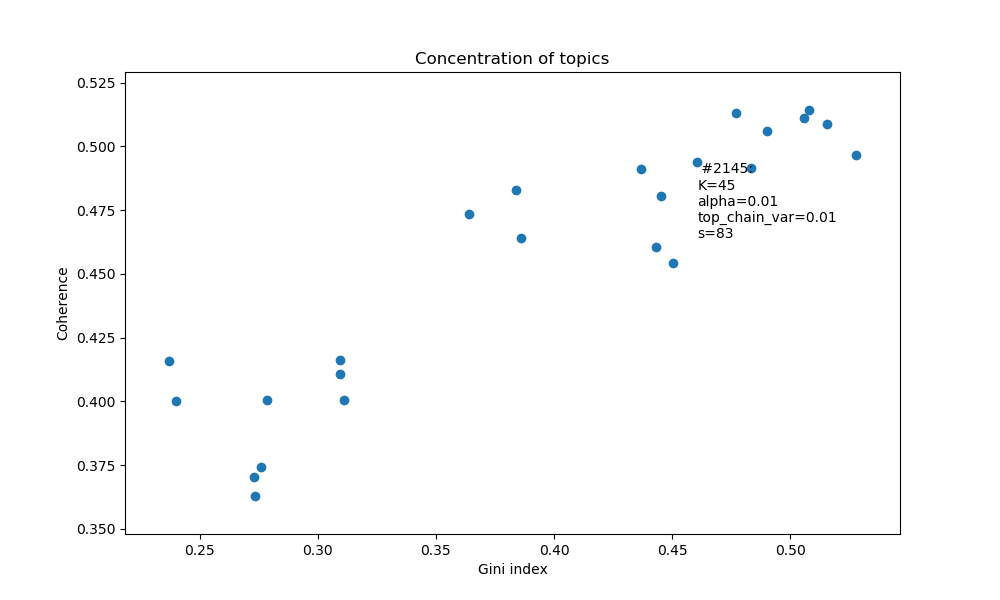

In [20]:
print("click on dots to show parameter settings")

x = df['gini']
y = df['coherence']

def onpick3(event):
    ind = event.ind[0]
    run_id = df.index[ind]
    label = " #{}:\nK={}\nalpha={}\ntop_chain_var={}\ns={}".format(run_id, select_df['K'][run_id],
                                                           select_df['alpha'][run_id],
                                                           select_df['top_chain_var'][run_id],
                                                           select_df['psearch__id'][run_id])
    text.set_text(label)
    text.set_x(x[run_id])
    text.set_y(y[run_id])


fig, ax = plt.subplots(figsize=(10,6))
col = ax.scatter(x, y, picker=5)
text=ax.text(0,0, "", va="top", ha="left")

fig.canvas.mpl_connect('pick_event', onpick3)

ax.set(xlabel="Gini index",ylabel="Coherence", title="Concentration of topics")

<IPython.core.display.Javascript object>


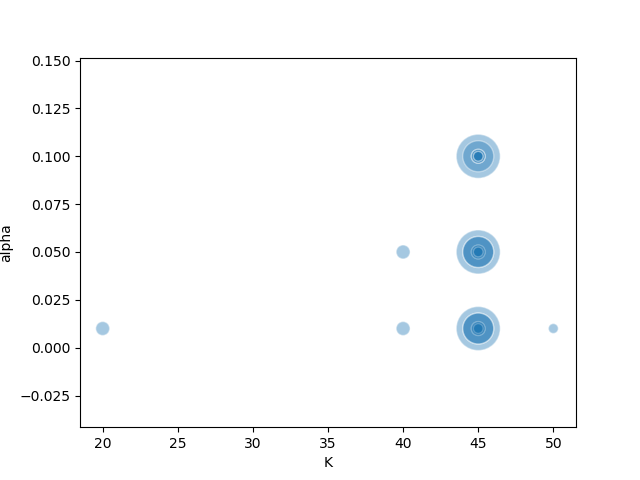

In [14]:
%matplotlib notebook

plt.scatter(x = df.K, 
            y = df.alpha, 
            s = df.top_chain_var*10000,
            alpha=0.4,
            edgecolors='w')

plt.xlabel('K')
plt.ylabel('alpha')

<IPython.core.display.Javascript object>


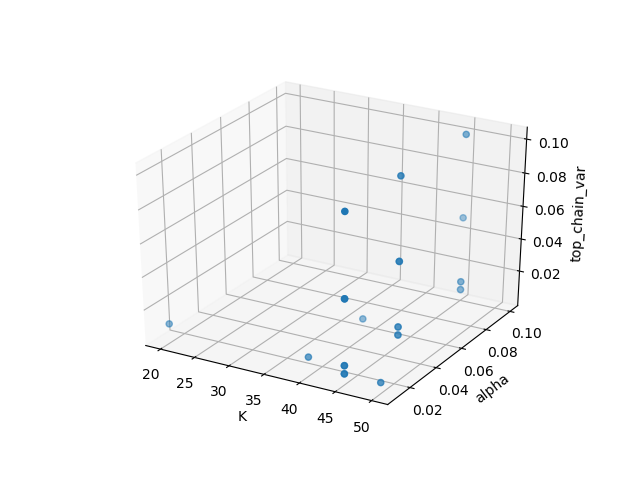

In [15]:
from mpl_toolkits.mplot3d import Axes3D

threedee = plt.figure().gca(projection='3d')

threedee.scatter(df.K, df.alpha, df.top_chain_var)
threedee.set_xlabel('K')
threedee.set_ylabel('alpha')
threedee.set_zlabel('top_chain_var')